# Import Modules and Data


In [1]:
from glob import glob
import geopandas as gp
import numpy as np
import pandas as pd
import pickle
import random
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.model_selection import ParameterGrid
import os

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 100

try:
    if kernel_is_loaded:
        pass
except:
    os.chdir('/'.join(os.getcwd().split('/')[:-1]))
    kernel_is_loaded = True

In [2]:
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

In [3]:
train = pd.read_csv('/wadhwani_kdss/c_drive/Users/user/abhijeeth/Code_Files_ML_models/data/train_3.csv')
test = pd.read_csv('/wadhwani_kdss/c_drive/Users/user/abhijeeth/Code_Files_ML_models/data/test_3.csv')
val = pd.read_csv('/wadhwani_kdss/c_drive/Users/user/abhijeeth/Code_Files_ML_models/data/val_3.csv')

In [4]:
train.columns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'last_fortnight', 'crop']
val.columns = train.columns
test.columns = val.columns 

In [5]:
X_train = train.drop(columns = ['last_fortnight','crop'], axis=1)
y_train = train['crop']

X_val = val.drop(columns = ['last_fortnight','crop'], axis=1)
y_val = val['crop']

X_test = test.drop(columns = ['last_fortnight','crop'], axis=1)
y_test = test['crop']

In [6]:
# scaler = StandardScaler()

# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# y_train.reset_index(drop=True, inplace=True)
# y_val.reset_index(drop=True, inplace=True)
# y_test.reset_index(drop=True, inplace=True)

In [7]:
def last_fn_zeroes(row):
    lst = deepcopy(row)
    lst.loc[int(row['last_fortnight'])] = 0
    return lst

In [8]:
params = {'n_estimators':np.arange(5,100,5), 'learning_rate':np.arange(0.05, 0.55, 0.05), 
          'max_depth':np.arange(1,5,1)}

# sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = list(ParameterGrid(params))
max_precision_scores = []
best_params = []
# fns_used = []


max_drops_allowed = train.last_fortnight.min() - 4

i = 0

train_last_fortnights, val_last_fortnights = train.last_fortnight, val.last_fortnight
temp_X_train, temp_X_val = deepcopy(X_train), deepcopy(X_val)

for i in range(max_drops_allowed+1):
    if i != 0:
        temp_X_train['last_fortnight'], temp_X_val['last_fortnight'] = train_last_fortnights, val_last_fortnights
        temp_X_train, temp_X_val = temp_X_train.apply(last_fn_zeroes, axis=1), temp_X_val.apply(last_fn_zeroes, axis=1)
        temp_X_train, temp_X_val = temp_X_train.drop('last_fortnight', axis=1), temp_X_val.drop('last_fortnight', axis=1)
        train_last_fortnights, val_last_fortnights = train_last_fortnights - 1, val_last_fortnights - 1
    precision_scores = np.empty((0,3), float)
    for p in param_grid:
        wheat_classifier = XGBClassifier(**p)
        wheat_classifier.fit(temp_X_train, y_train)
        val_pred = wheat_classifier.predict(temp_X_val)  #
        precision, recall, f1score, support = score(y_val, val_pred, labels=[0,1,2])
        precision_scores = np.vstack([precision_scores, precision])
        
    precision_scores = pd.DataFrame(precision_scores)
    hms = precision_scores.apply(lambda row : len(row) / np.sum(1.0 / row) if (np.all(row > 0.85)) else 0, axis=1).values
    best_hm = np.max(hms)
    if best_hm != 0:
        best_hm_idx = np.argmax(hms)
        best_params.append(param_grid[best_hm_idx])
        max_precision_scores.append(best_hm)    
        # fns_used.append('-'.join(map(str, temp_X_train.columns[[0,-1]])))
        print(i , 'fns dropped completed with best harmonic mean of', best_hm, 'precision on validation data')
    else:
        print(i , 'fns dropped completed and unable to find atleast 0.85 precision on validation data w.r.t each class')
    
    i += 1
    
print('Done!!')

0 fns dropped completed with best harmonic mean of 0.8767707147620788 precision on validation data
1 fns dropped completed and unable to find atleast 0.85 precision on validation data w.r.t each class
2 fns dropped completed and unable to find atleast 0.85 precision on validation data w.r.t each class
Done!!


In [9]:
test_reports = []
test_precision_scores = []
confusion_matrices = []
# test_dfs = []
best_models = []
y_pred = []

train_last_fortnights, test_last_fortnights = train.last_fortnight, test.last_fortnight
temp_X_train, temp_X_test = deepcopy(X_train), deepcopy(X_test)

for i in range(max_drops_allowed+1):
    if i != 0:
        temp_X_train['last_fortnight'], temp_X_test['last_fortnight'] = train_last_fortnights, test_last_fortnights
        temp_X_train, temp_X_test = temp_X_train.apply(last_fn_zeroes, axis=1), temp_X_test.apply(last_fn_zeroes, axis=1)
        temp_X_train, temp_X_test = temp_X_train.drop('last_fortnight', axis=1), temp_X_test.drop('last_fortnight', axis=1)
        train_last_fortnights, test_last_fortnights = train_last_fortnights - 1, test_last_fortnights - 1
    # precision_scores = np.empty((0,3), float)
    best_classifier = XGBClassifier(**best_params[i])
    best_classifier.fit(temp_X_train, y_train)
    best_models.append(best_classifier)
# #     pickle.dump(best_classifier, open(r'models/XGB_Binary_sowing-nov1f_{}_1.1'.format('-'.join(temp_X_train.columns[[0,-1]])), 'wb'))
    test_pred = best_classifier.predict(temp_X_test)
    y_pred.append(test_pred)
    report = classification_report(y_test, test_pred, target_names=['Mustard', 'Wheat','potato'], output_dict=True)
    df = pd.DataFrame(report).transpose().loc[:'potato',:'f1-score']
    test_reports.append(df)
    test_precision_scores.append(df['precision'].values)
    print(i, 'fortnights dropped')
    display(test_reports[i])
    cf = pd.crosstab(y_test, pd.Series(test_pred, name='pred')).rename({0:'Mustard', 1:'Wheat', 2: 'Potato'}).rename({0:'Mustard', 1:'Wheat' ,2:'Potato'}, axis=1)
    confusion_matrices.append(cf)

0 fortnights dropped


precision    recall  f1-score
Mustard   0.851064  0.101781  0.181818
Wheat     0.881822  0.995470  0.935206
potato    0.903955  0.554593  0.687433

IndexError: list index out of range

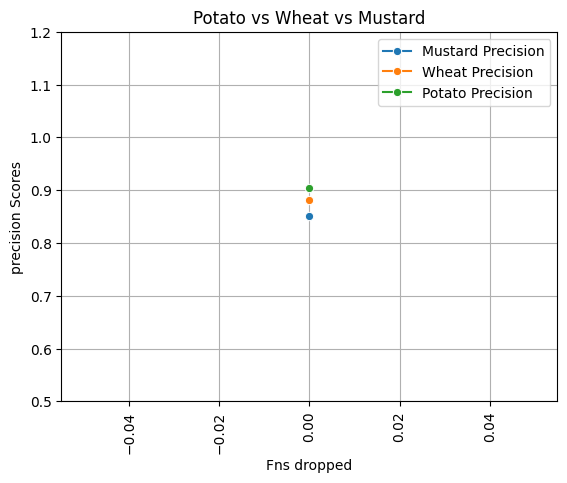

In [12]:
sns.lineplot(y=np.array(test_precision_scores)[:,0], x=[0], label='Mustard Precision', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,1], x=[0], label='Wheat Precision', marker="o")
sns.lineplot(y=np.array(test_precision_scores)[:,2], x=[0], label='Potato Precision', marker="o")
plt.xlabel('Fns dropped')
plt.ylabel('precision Scores')
plt.xticks(rotation='vertical')
plt.title('Potato vs Wheat vs Mustard')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

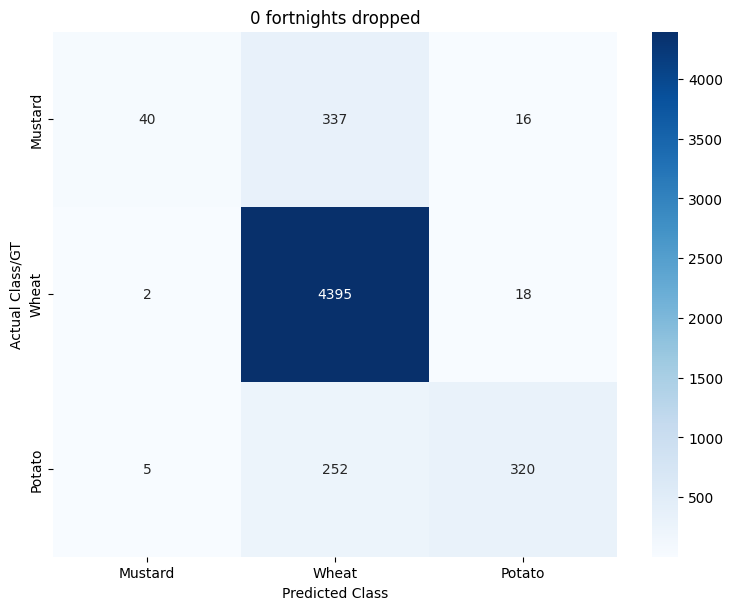

In [13]:
plt.figure(figsize=(20,15))

for i in range(len(confusion_matrices)):
    plt.subplot(2,2,i+1)
    sns.heatmap(confusion_matrices[i], annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class/GT')
    plt.title(f'{i} fortnights dropped')
plt.show()

In [16]:
test['pred'] = best_models[0].predict(X_test)

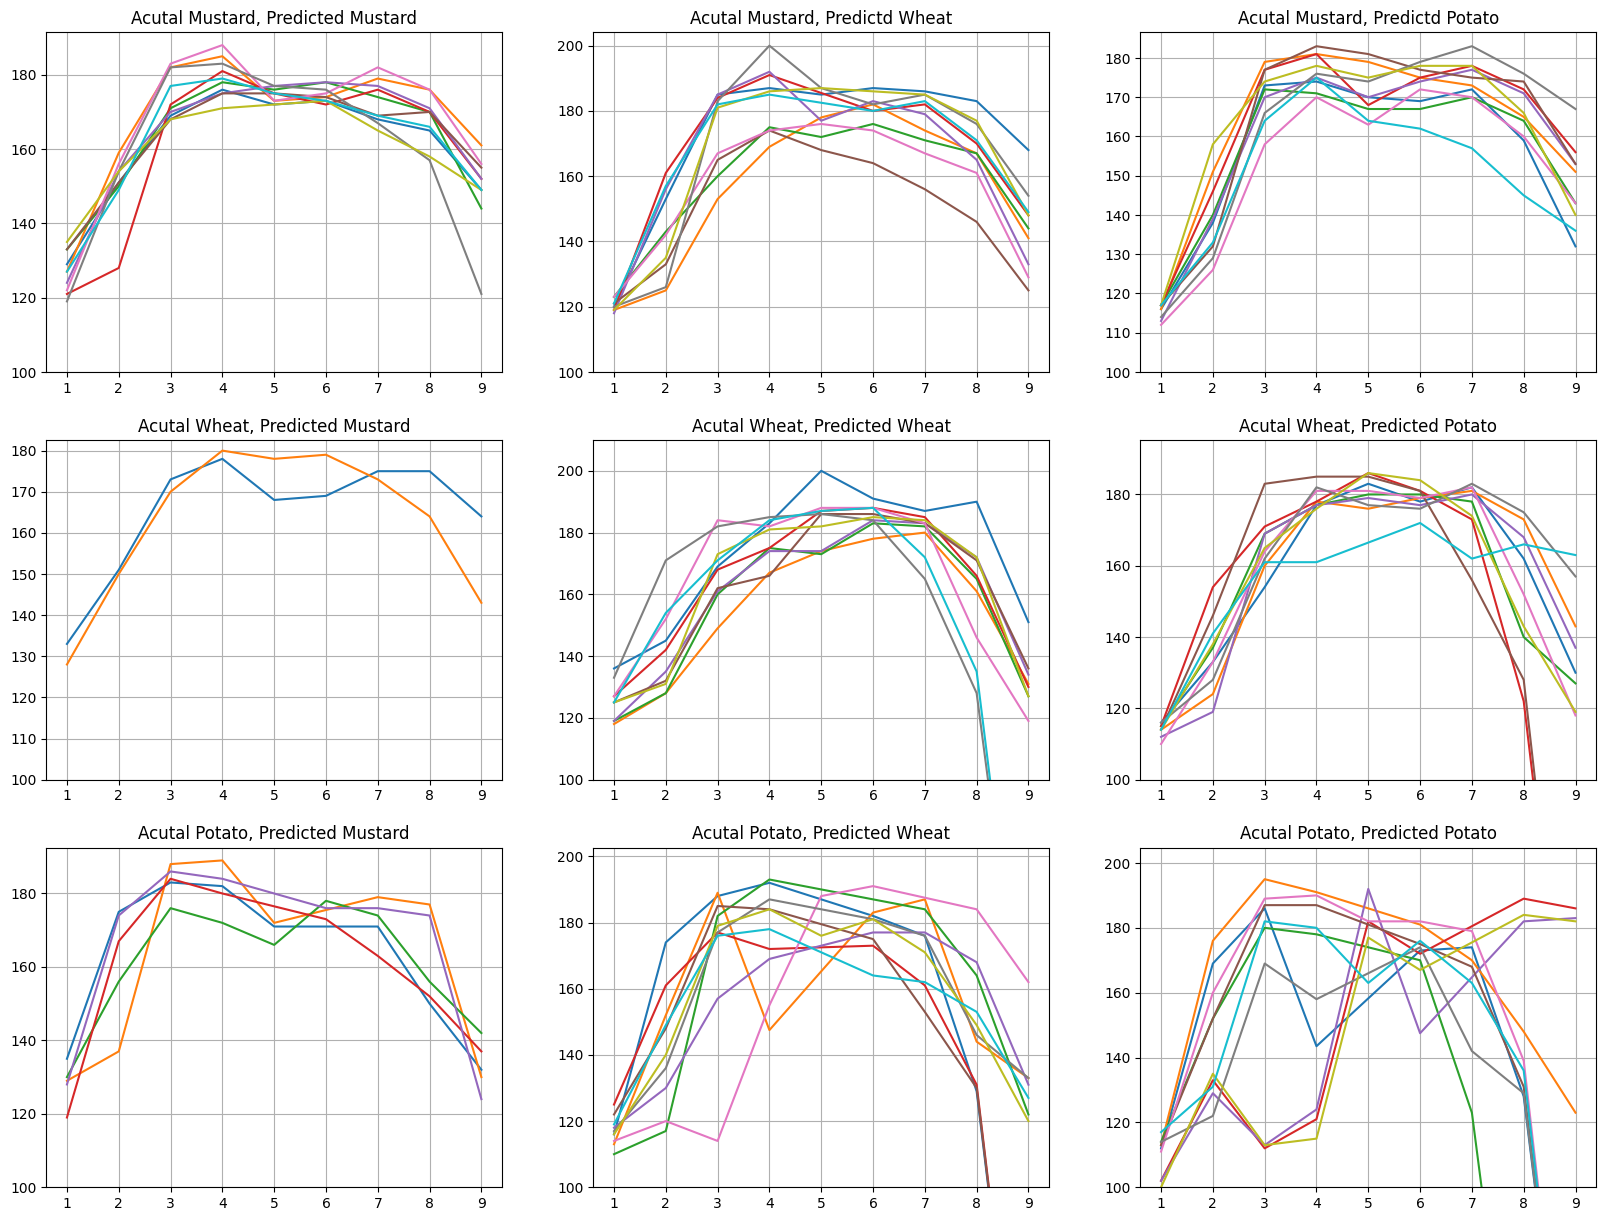

In [18]:
plt.rcParams['axes.grid'] = True

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(3,3,1)
ax.plot(test[(test['crop'] == 0) & (test['pred'] == 0)].loc[:,:9].sample(10, random_state=42).T)
plt.title('Acutal Mustard, Predicted Mustard')
plt.ylim(100)
ax = fig.add_subplot(3,3,2)
ax.plot(test[(test['crop'] == 0) & (test['pred'] == 1)].loc[:,:9].sample(10,random_state = 42).T)
plt.title('Acutal Mustard, Predictd Wheat')
plt.ylim(100)
ax = fig.add_subplot(3,3,3)
ax.plot(test[(test['crop'] == 0) & (test['pred'] == 2)].loc[:,:9].sample(10,random_state=42).T)
plt.title('Acutal Mustard, Predictd Potato')
plt.ylim(100)
ax = fig.add_subplot(3,3,4)
ax.plot(test[(test['crop'] == 1) & (test['pred'] == 0)].loc[:,:9].sample(2, random_state=42).T)
plt.title('Acutal Wheat, Predicted Mustard')
plt.ylim(100)
ax = fig.add_subplot(3,3,5)
ax.plot(test[(test['crop'] == 1) & (test['pred'] == 1)].loc[:,:9].sample(10, random_state=42).T)
plt.title('Acutal Wheat, Predicted Wheat')
plt.ylim(100)
ax = fig.add_subplot(3,3,6)
ax.plot(test[(test['crop'] == 1) & (test['pred'] == 2)].loc[:,:9].sample(10, random_state=42).T)
plt.title('Acutal Wheat, Predicted Potato')
plt.ylim(100)
ax = fig.add_subplot(3,3,7)
ax.plot(test[(test['crop'] == 2) & (test['pred'] == 0)].loc[:,:9].sample(5, random_state=42).T)
plt.title('Acutal Potato, Predicted Mustard')
plt.ylim(100)
ax = fig.add_subplot(3,3,8)
ax.plot(test[(test['crop'] == 2) & (test['pred'] == 1)].loc[:,:9].sample(10, random_state=42).T)
plt.title('Acutal Potato, Predicted Wheat')
plt.ylim(100)
ax = fig.add_subplot(3,3,9)
ax.plot(test[(test['crop'] == 2) & (test['pred'] == 2)].loc[:,:9].sample(10, random_state=42).T)
plt.title('Acutal Potato, Predicted Potato')
plt.ylim(100)
plt.savefig('classification.png')
plt.show()

In [56]:
class _conformal_prediction:
    def __init__(self, estimator):
        self.estimator = estimator
        self.quantile = None
        self.coverage = None
    def fit(self, X_cal, y_cal, alpha):
        cal_pred_proba = self.estimator.predict_proba(X_cal)
        scores = 1 - cal_pred_proba
        true_class_scores = list(map(lambda row, idx:row[idx], scores, y_cal))
        n = X_cal.shape[0]
        self.coverage = (n+1)*(1 - alpha)/n
        self.quantile = np.quantile(true_class_scores, self.coverage)
    def predict(self, X_test):
        test_pred_proba = self.estimator.predict_proba(X_test)
        scores = 1 - test_pred_proba
        def func(crop):
            crop_set = (crop <= self.quantile).nonzero()[0]
            if len(crop_set) == 0:
                return 'nan'
            else:
                return ' '.join(list(map(str, crop_set)))
        pred_set = list(map(func, scores))
        return test_pred_proba, pred_set

In [57]:
best_model = best_models[1]
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=95, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [58]:
alphas = np.arange(0.01,0.16,0.01)
cp = _conformal_prediction(best_model)
accuracy = []
confusion_matrices = []

In [59]:
for alpha in alphas:
    cp.fit(X_val, y_val, alpha)
    y_test_pred = list(map(str, y_test))
    predictions = cp.predict(X_test)[1]

    labels = ['0','1','2']
    
    # Initialize the correct_predictions dictionary with zeros for each label
    
    correct_predictions = {label: 0 for label in labels}
    
    for i in range(0, len(y_test_pred)):
        if y_test_pred[i] == predictions[i]:
            correct_predictions[y_test_pred[i]] += 1

    # Calculate prediction counts
    prediction_counts = pd.Series(y_test_pred).value_counts()

    accuracy.append([correct_predictions[label] / prediction_counts[label] for label in labels]) 
    
    cf = pd.crosstab(pd.Series(predictions, name='pred') ,y_test)
    confusion_matrices.append(cf)

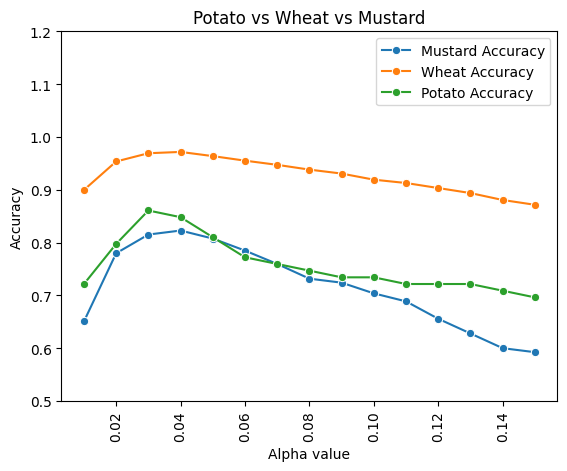

In [60]:
sns.lineplot(y=np.array(accuracy)[:,0], x= alphas, label='Mustard Accuracy', marker="o")
sns.lineplot(y=np.array(accuracy)[:,1], x= alphas, label='Wheat Accuracy', marker="o")
sns.lineplot(y=np.array(accuracy)[:,2], x= alphas, label='Potato Accuracy', marker="o")
plt.xlabel('Alpha value')
plt.ylabel('Accuracy')
plt.xticks(rotation='vertical')
plt.title('Potato vs Wheat vs Mustard')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

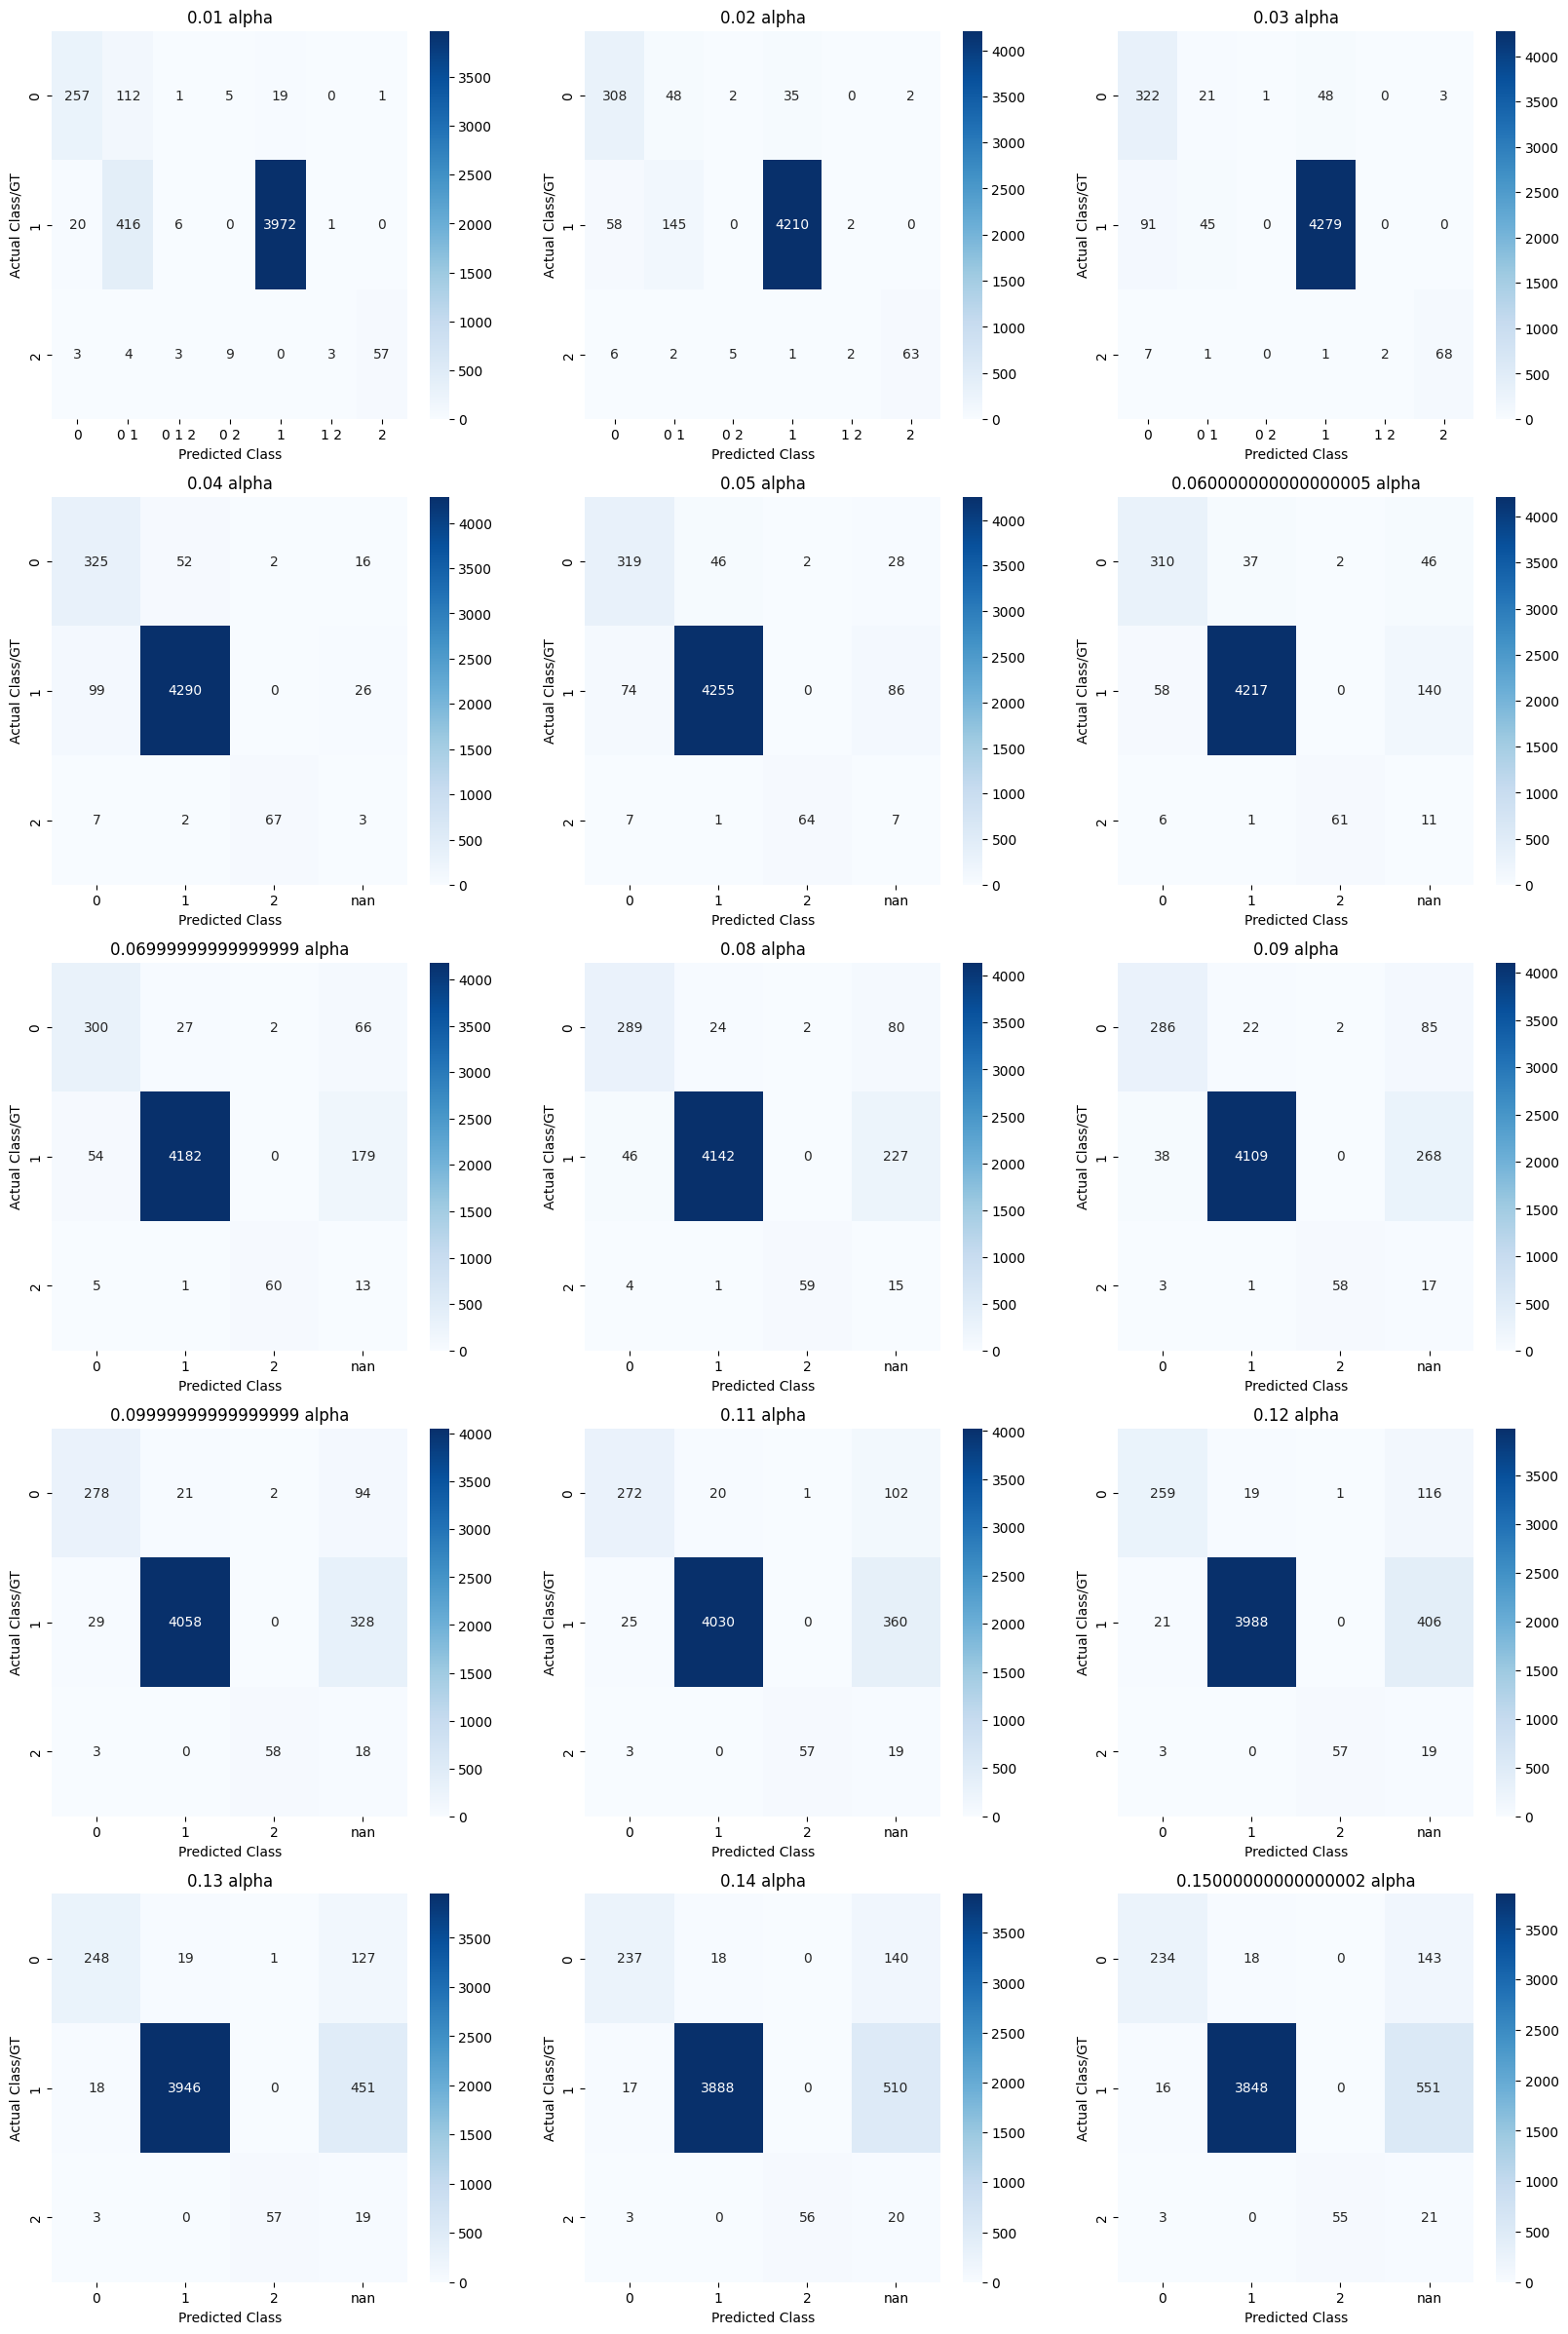

In [62]:
plt.rcParams['axes.grid'] = False
plt.figure(figsize=(20,30))
for i in range(len(confusion_matrices)):
    plt.subplot(5,3,i+1)
    sns.heatmap(confusion_matrices[i].T, annot=True, cmap='Blues', fmt='g')
    plt.ylabel('Actual Class/GT')
    plt.xlabel('Predicted Class')
    plt.title(f'{alphas[i]} alpha')

plt.show()

In [63]:
alphas = np.arange(0.01,0.16,0.01)
cp = _conformal_prediction(best_model)
accuracy = []
confusion_matrices = []

In [64]:
for alpha in alphas:
    cp.fit(X_val, y_val, alpha)
    y_test_pred = list(map(str, y_test))
    predictions = cp.predict(X_test)[1]

    labels = ['0','1','2']
    
    # Initialize the correct_predictions dictionary with zeros for each label
    
    correct_predictions = {label: 0 for label in labels}
    
    for i in range(0, len(y_test_pred)):
        if y_test_pred[i] in predictions[i]:
            correct_predictions[y_test_pred[i]] += 1

    # Calculate prediction counts
    prediction_counts = pd.Series(y_test_pred).value_counts()

    accuracy.append([correct_predictions[label] / prediction_counts[label] for label in labels]) 
    
    cf = pd.crosstab(pd.Series(predictions, name='pred') ,y_test)
    confusion_matrices.append(cf)

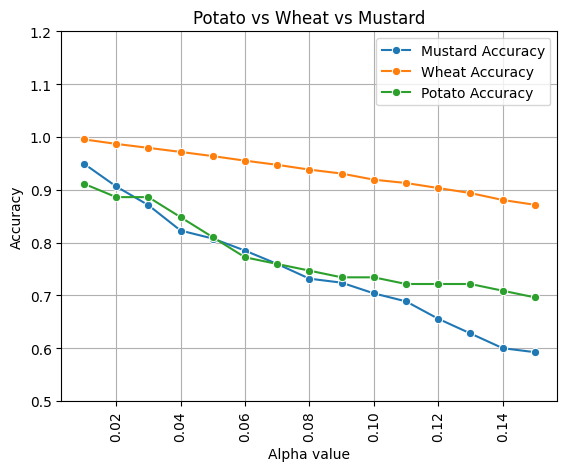

In [65]:
sns.lineplot(y=np.array(accuracy)[:,0], x= alphas, label='Mustard Accuracy', marker="o")
sns.lineplot(y=np.array(accuracy)[:,1], x= alphas, label='Wheat Accuracy', marker="o")
sns.lineplot(y=np.array(accuracy)[:,2], x= alphas, label='Potato Accuracy', marker="o")
plt.xlabel('Alpha value')
plt.ylabel('Accuracy')
plt.xticks(rotation='vertical')
plt.title('Potato vs Wheat vs Mustard')
plt.ylim([0.5,1.2])
plt.grid()
plt.show()

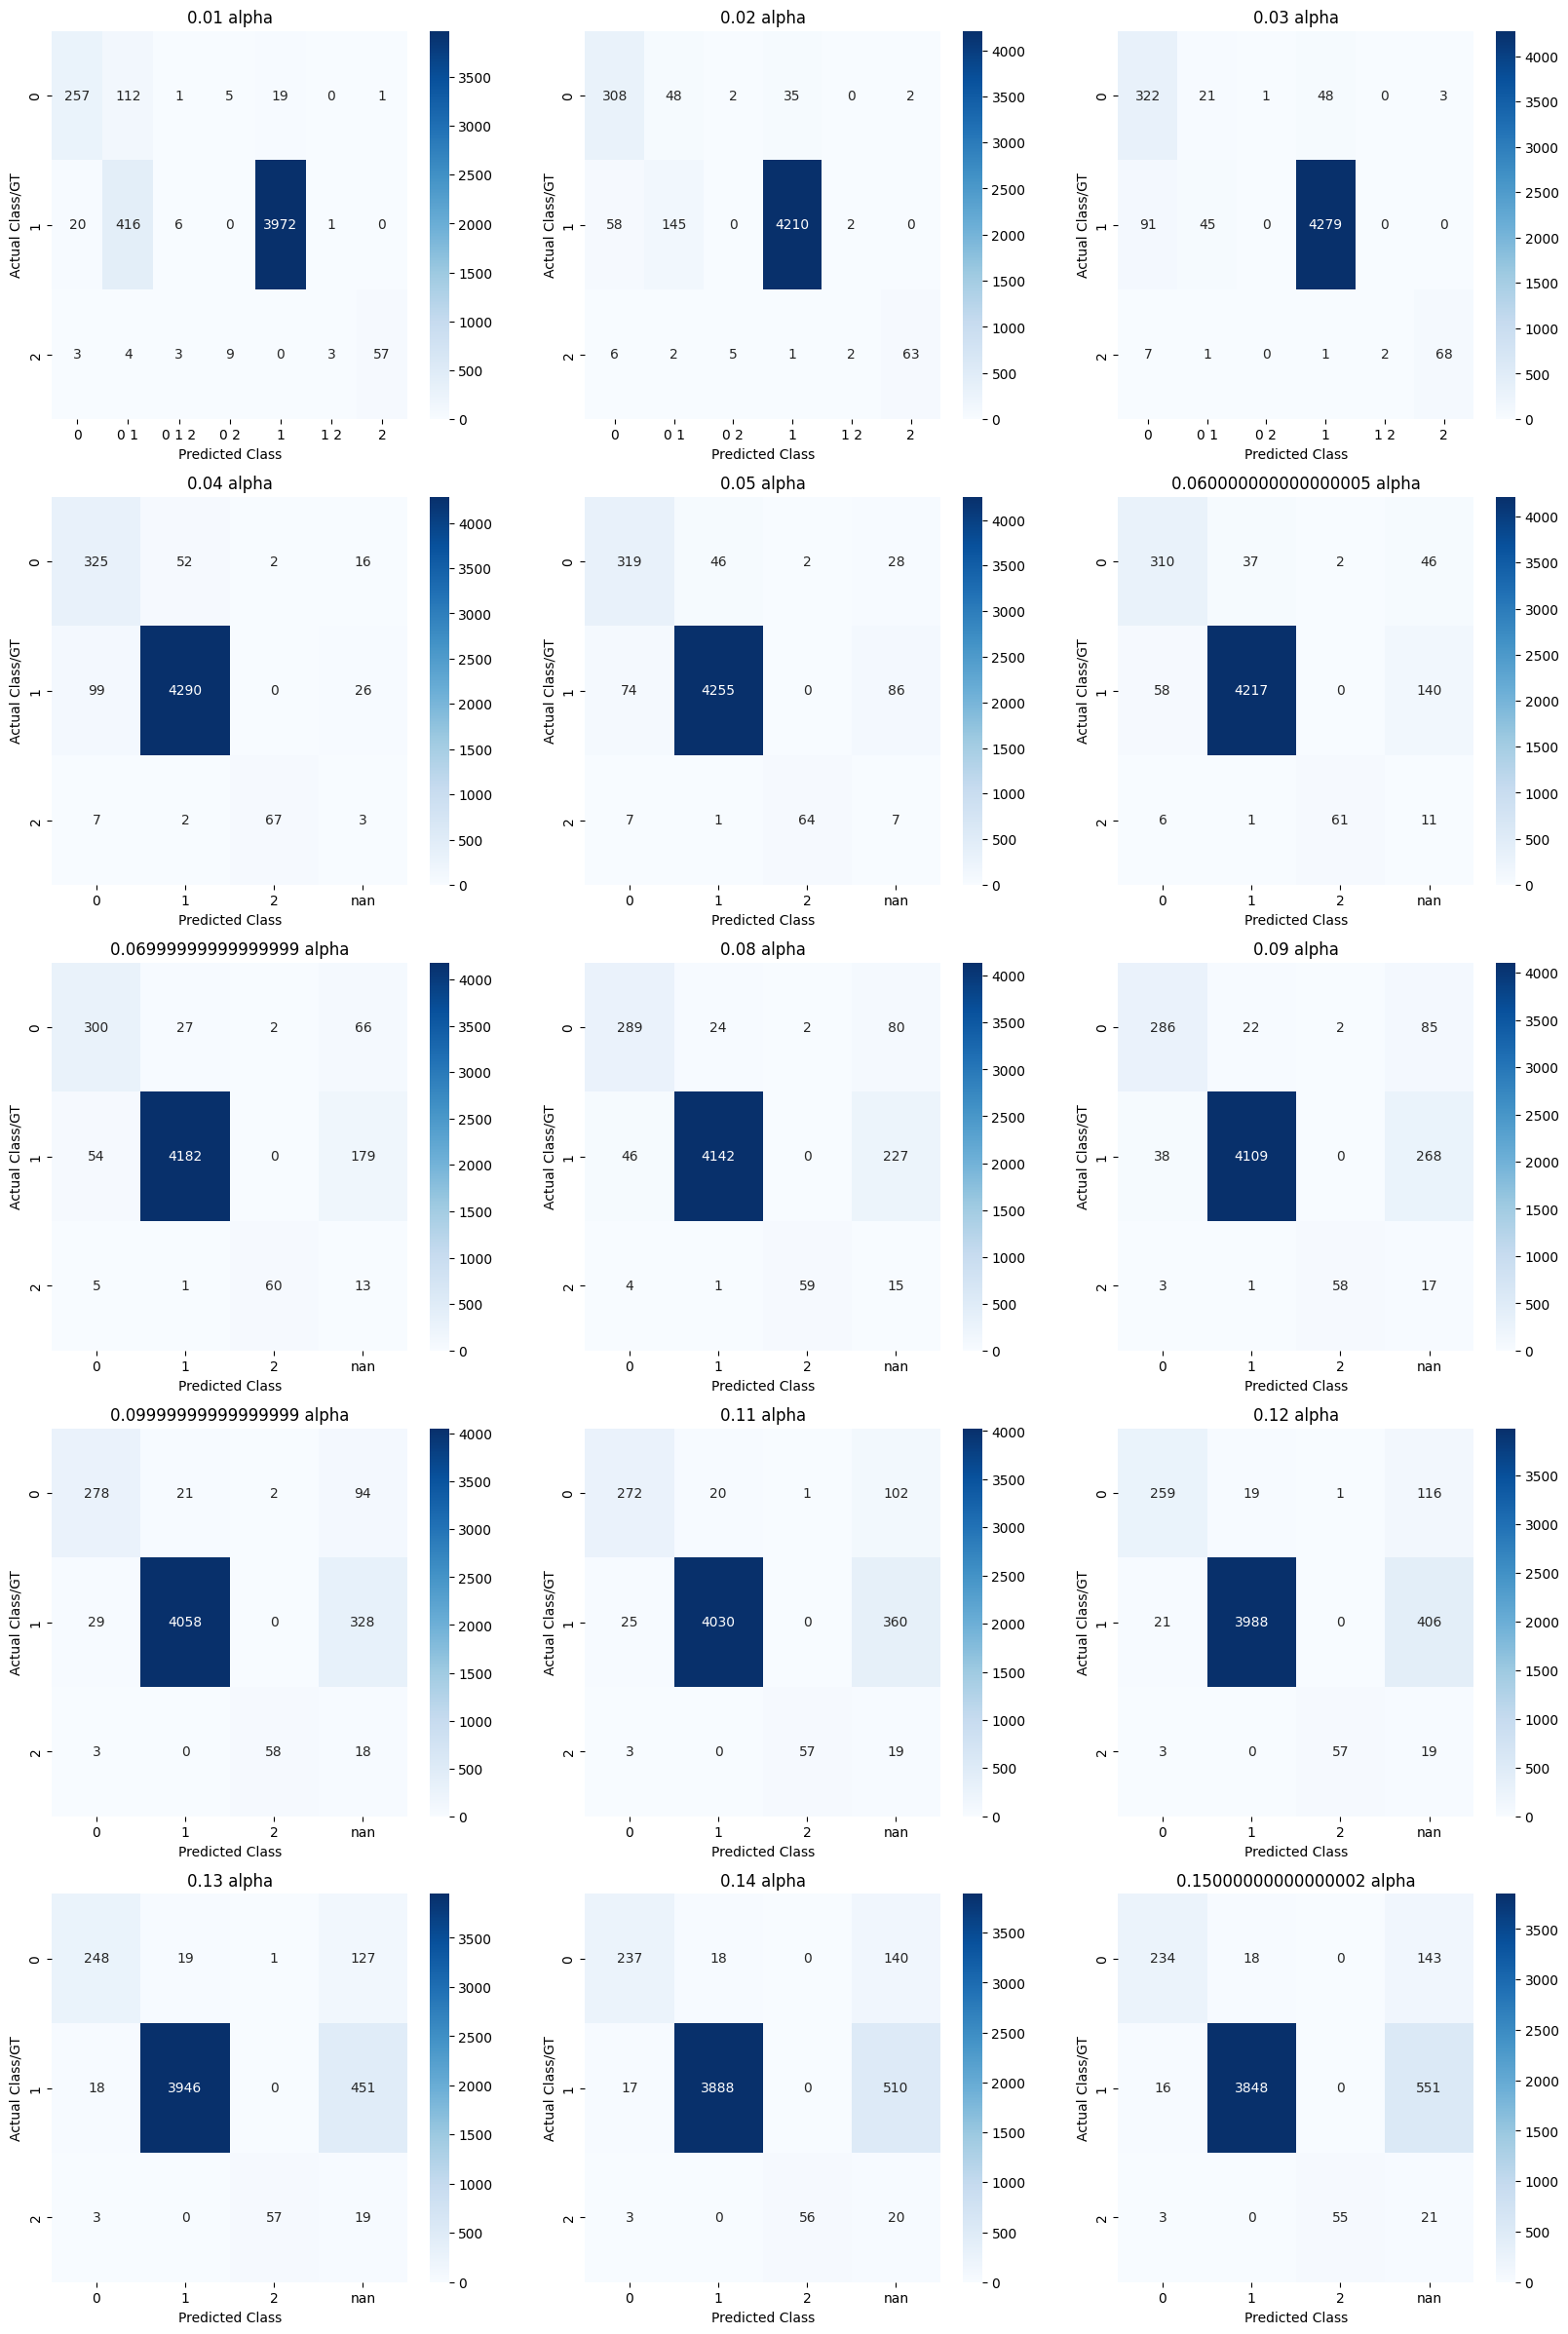

In [66]:
plt.figure(figsize=(20,30))
for i in range(len(confusion_matrices)):
    plt.subplot(5,3,i+1)
    sns.heatmap(confusion_matrices[i].T, annot=True, cmap='Blues', fmt='g')
    plt.ylabel('Actual Class/GT')
    plt.xlabel('Predicted Class')
    plt.title(f'{alphas[i]} alpha')

plt.show()

In [72]:
cp.fit(X_val, y_val, 0.03)
test['alpha 0.03'] = cp.predict(X_test)[1]
cp.fit(X_val, y_val, 0.01)
test['alpha 0.01'] = cp.predict(X_test)[1]

In [73]:
rows = test.loc[:,'crop'].unique()
cols = test.loc[:,'alpha 0.01'].unique()

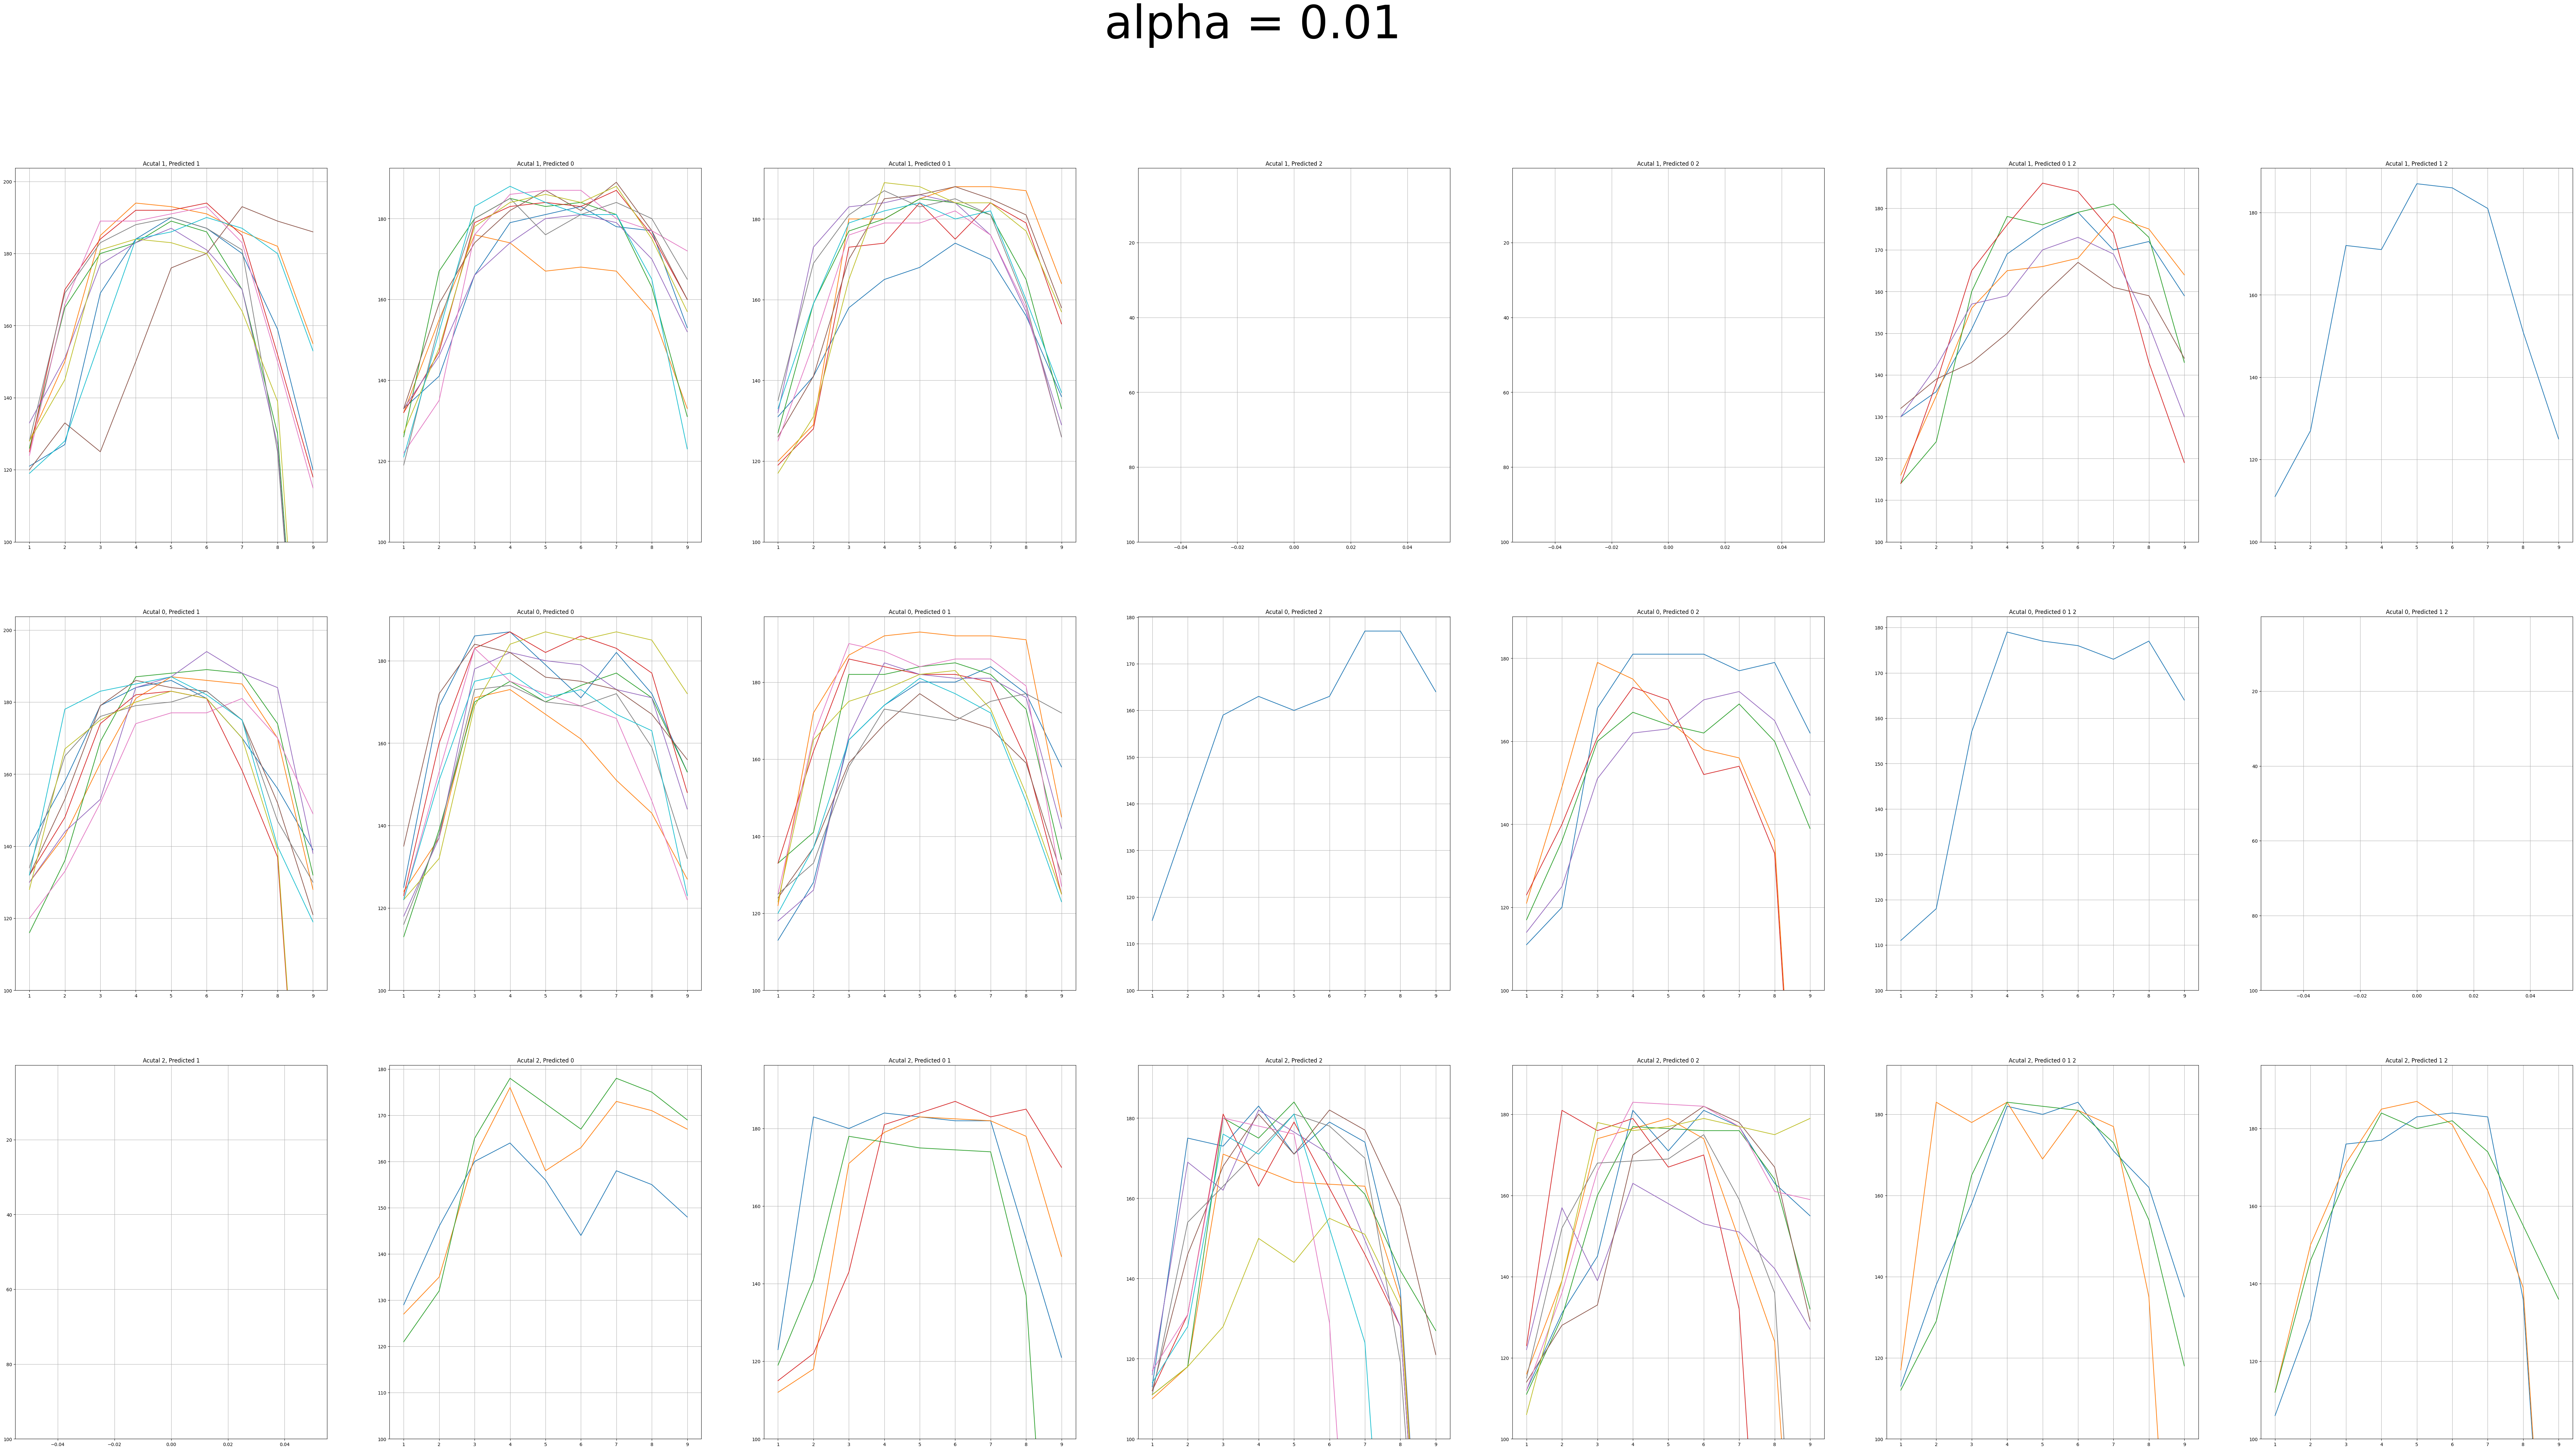

In [90]:
plt.rcParams['axes.grid'] = True

fig = plt.figure(figsize = (100,50))
for i in range(len(rows)):
    for j in range(len(cols)):
        ax = fig.add_subplot(3,7,len(cols)*i+j+1)
        data = test[(test['crop'] == rows[i]) & (test['alpha 0.01']== cols[j])]
        ax.plot(data.loc[:,:9].sample(min(data.shape[0],10), random_state=42).T)
        plt.title(f'Acutal {rows[i]}, Predicted {cols[j]}')
        plt.ylim(100)

plt.suptitle('alpha = 0.01',fontsize = 100)
plt.savefig('classification_alpha_0.01.png')
plt.show()
    

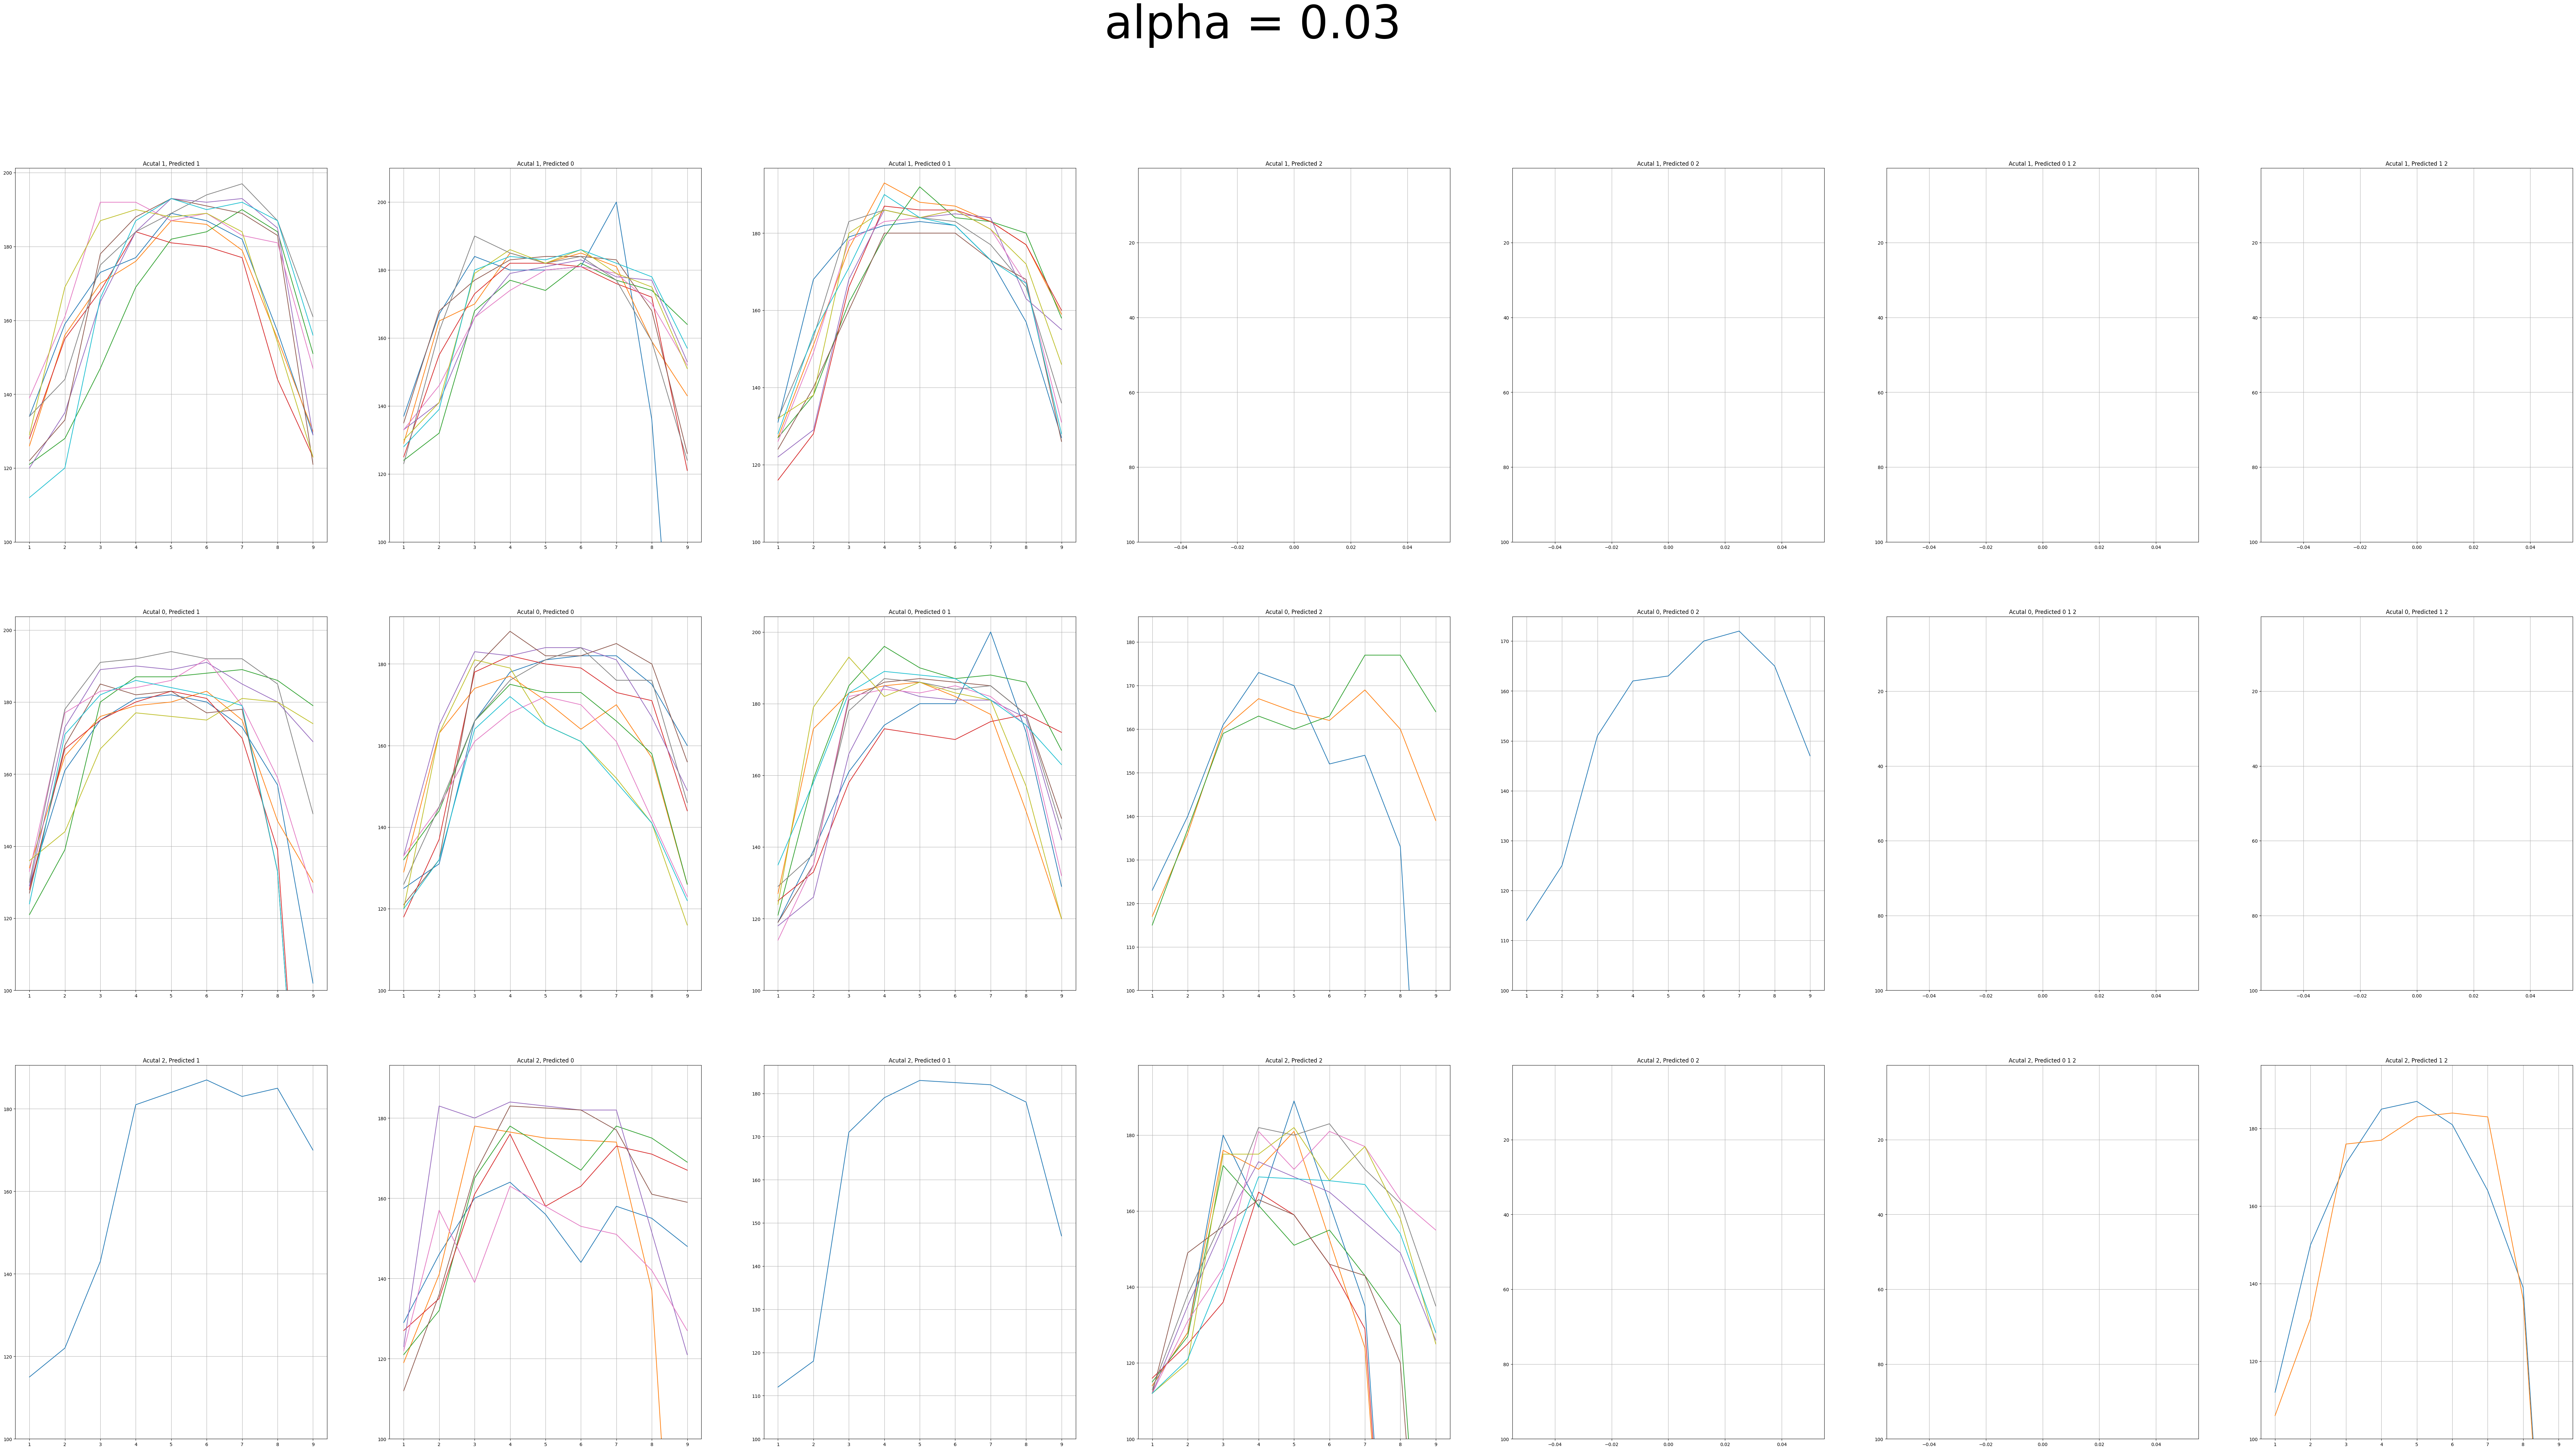

In [92]:
plt.rcParams['axes.grid'] = True

fig = plt.figure(figsize = (100,50))
for i in range(len(rows)):
    for j in range(len(cols)):
        ax = fig.add_subplot(3,7,len(cols)*i+j+1)
        data = test[(test['crop'] == rows[i]) & (test['alpha 0.03']== cols[j])]
        ax.plot(data.loc[:,:9].sample(min(data.shape[0],10), random_state=42).T)
        plt.title(f'Acutal {rows[i]}, Predicted {cols[j]}')
        plt.ylim(100)

plt.suptitle('alpha = 0.03',fontsize = 100)
plt.savefig('classification_alpha_0.03.png')
plt.show()
    